In [ ]:
#community detection using louvain algorithm

Number of communities detected: 20
Community detection results saved to 'community_detection_output_louvine.csv'


C:\Users\bshar\AppData\Local\Temp\ipykernel_19100\581372446.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('rainbow', len(unique_communities))  # Use a rainbow colormap


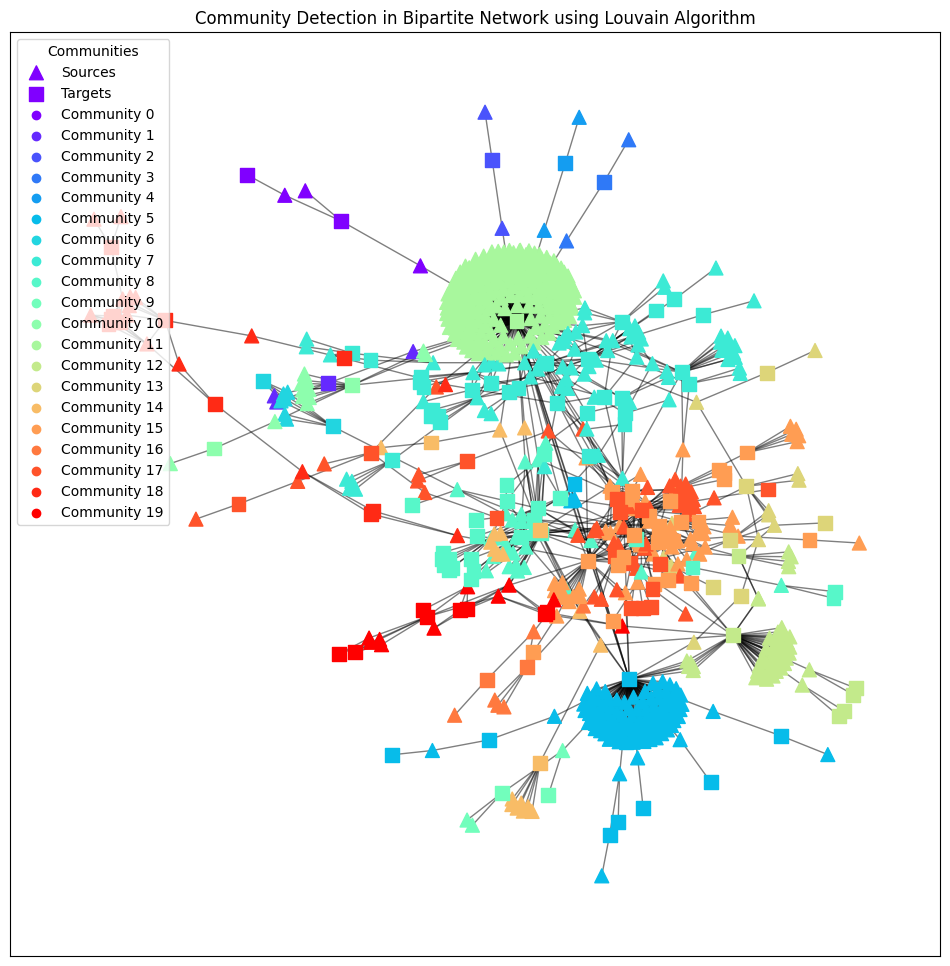

Nodes grouped by communities:
Community 0: ['IRAK2 ', 'TRAF6 ', 'DDX3X ', ' P68467', ' Q8V2D1']
Community 1: ['CCDC14 ', 'CTSC ', 'MAPK7 ', ' Q777C3']
Community 2: ['RPL4 ', 'NR4A1 ', ' P12977']
Community 3: ['CSNK2B ', 'PPARG ', ' P26662']
Community 4: ['HIST1H2AI ', 'STAT3 ', ' Q9DUM3']
Community 5: ['HAX1 ', 'HNRNPK ', 'KHDRBS1 ', 'SF3B2 ', 'MAGED1 ', 'HNRNPA2B1 ', 'HSPA8 ', 'SET ', 'AKAP8L ', 'ALDH1B1 ']
Community 6: ['BAD ', 'BAX ', 'BID ', 'BCL2L11 ', 'PMAIP1 ', 'BBC3 ', ' P17361', ' P68451']
Community 7: ['PSMA3 ', 'PKM ', 'ZYX ', 'TSG101 ', 'ENOX2 ', 'GPRASP1 ', 'ARMCX5-GPRASP2 ', 'TSC22D4 ', 'RABAC1 ', 'TRADD ']
Community 8: ['RCN2 ', 'CCNT1 ', 'TP73 ', 'TP53 ', 'GPS2 ', 'BRCA1 ', 'BAK1 ', 'PTPN3 ', 'UBE3A ', 'MAGI1 ']
Community 9: ['UBC ', 'SOCS1 ', 'TUBA3D ', ' P05888', ' P04325']
Community 10: ['HLA-A ', 'ATP6V0A1 ', 'CCHCR1 ', 'GAPDH ', 'HLA-B ', 'IGLL1 ', 'NUCB2 ', 'CIR1 ', 'RPL3 ', 'CERS4 ']
Community 11: ['GNB2 ', 'GLYR1 ', 'GOLGA2 ', 'GON4L ', 'GIN1 ', 'GFAP ', 'HIVEP2

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import community as community_louvain

# Path to your CSV file
file_path = 'bipartite_host_viral.csv'  # Replace with your actual file path

# Load data
bipartite_data = pd.read_csv(file_path)

# Ensure the CSV has 'source' and 'target' columns
sources = bipartite_data['source']
targets = bipartite_data['target']

# Create a bipartite graph
B = nx.Graph()
B.add_nodes_from(sources, bipartite=0)  # Add source nodes (type 0)
B.add_nodes_from(targets, bipartite=1)  # Add target nodes (type 1)
B.add_edges_from(zip(sources, targets))  # Add edges between sources and targets

# Check if the graph is bipartite
if not bipartite.is_bipartite(B):
    raise ValueError("The graph is not bipartite!")

# Use Louvain modularity to detect communities while maintaining bipartite structure
partition = community_louvain.best_partition(B, resolution=1.0)  # Resolution can tune community granularity

# Extract communities
num_communities = len(set(partition.values()))
print(f"Number of communities detected: {num_communities}")

# Add community labels to the graph
nx.set_node_attributes(B, partition, 'community')

# Format community data directly for saving to CSV
community_data = {
    'Community': [f"Community {community_id}: {nodes}" for community_id, nodes in 
                  {community_id: [node for node, community in partition.items() if community == community_id] 
                   for community_id in set(partition.values())}.items()]
}

# Create DataFrame and save directly to CSV
community_df = pd.DataFrame(community_data)
community_df.to_csv('community_detection_output_louvine.csv', index=False)
print("Community detection results saved to 'community_detection_output_louvine.csv'")

# Visualize the communities
plt.figure(figsize=(12, 12))
plt.title("Community Detection in Bipartite Network using Louvain Algorithm")

# Assign colors to nodes based on their community
node_colors = [partition[node] for node in B.nodes()]
unique_communities = set(partition.values())
cmap = plt.cm.get_cmap('rainbow', len(unique_communities))  # Use a rainbow colormap

# Use a spring layout for visualization
pos = nx.spring_layout(B)

# Draw source nodes (type 0) as triangles
source_nodes = [node for node in B.nodes() if B.nodes[node]['bipartite'] == 0]
nx.draw_networkx_nodes(
    B, pos,
    nodelist=source_nodes,
    node_color=[cmap(partition[node] / len(unique_communities)) for node in source_nodes],
    node_size=100,
    node_shape='^',  # Triangle
    label="Sources"
)

# Draw target nodes (type 1) as squares
target_nodes = [node for node in B.nodes() if B.nodes[node]['bipartite'] == 1]
nx.draw_networkx_nodes(
    B, pos,
    nodelist=target_nodes,
    node_color=[cmap(partition[node] / len(unique_communities)) for node in target_nodes],
    node_size=100,
    node_shape='s',  # Square
    label="Targets"
)

# Draw edges
nx.draw_networkx_edges(B, pos, alpha=0.5)

# Add legend for communities
for community_id in unique_communities:
    plt.scatter([], [], color=cmap(community_id / len(unique_communities)), label=f"Community {community_id}")
plt.legend(scatterpoints=1, loc='upper left', title="Communities")

# Save the output image
plt.savefig('community_detection_bipartite_louvain.png', format='PNG')

# Display the plot
plt.show()

# Print example nodes in each community
print("Nodes grouped by communities:")
community_groups = {community_id: [] for community_id in unique_communities}
for node, community in partition.items():
    community_groups[community].append(node)

for community_id, nodes in community_groups.items():
    print(f"Community {community_id}: {nodes[:10]}")  # Display first 10 nodes for brevity


In [ ]:
#community detection using leiden algorithm

Number of communities detected: 24
Community detection results saved to 'community_detection_output_leiden_formatted.csv'


C:\Users\bshar\AppData\Local\Temp\ipykernel_19100\2667407359.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('rainbow', len(unique_communities))  # Use a rainbow colormap


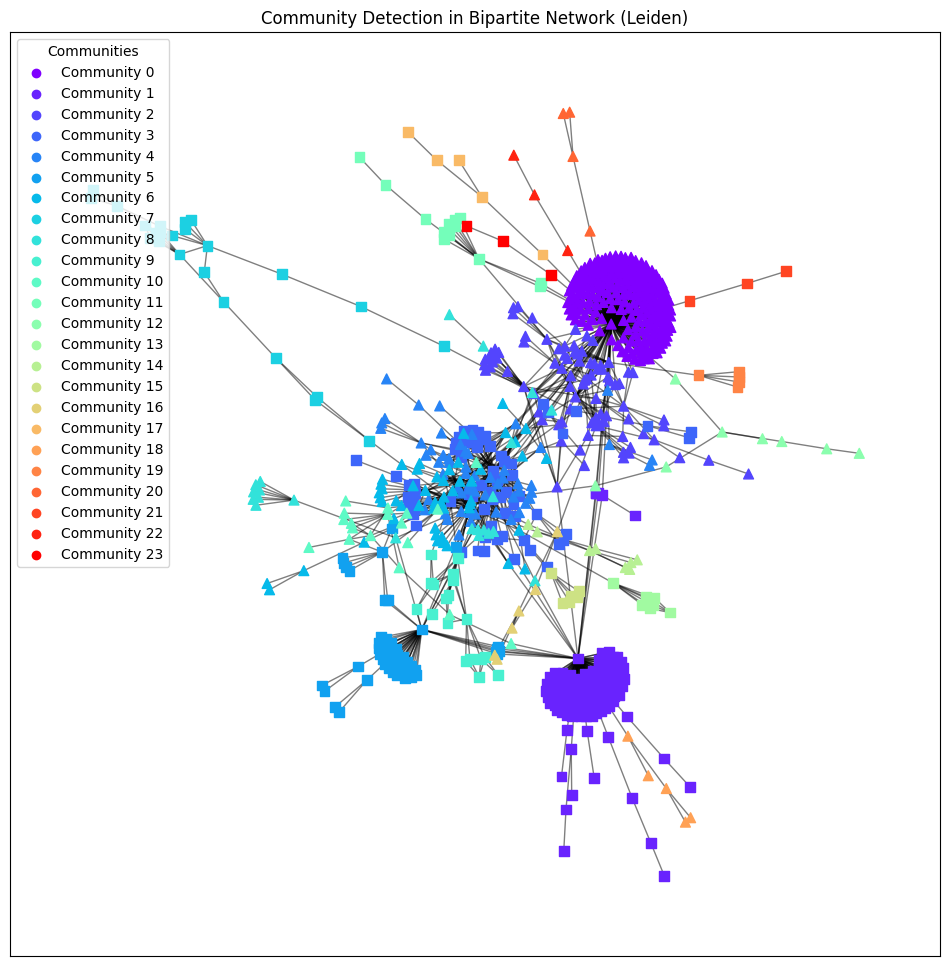

Nodes grouped by communities:
Community 0: ['GNB2 ', 'GLYR1 ', 'GOLGA2 ', 'GON4L ', 'GIN1 ', 'GFAP ', 'HIVEP2 ', 'HOXD8 ', 'GBP2 ', 'HSFX2 ']
Community 1: ['HAX1 ', 'HNRNPK ', 'KHDRBS1 ', 'SF3B2 ', 'MAGED1 ', 'HNRNPA2B1 ', 'HSPA8 ', 'SET ', 'AKAP8L ', 'ALDH1B1 ']
Community 2: ['PSMA3 ', 'TRAF2 ', 'IKBKG ', 'GRN ', 'ACTN1 ', 'LMNB1 ', 'SLIT2 ', 'PSME3 ', 'RNF31 ', 'MMRN2 ']
Community 3: ['CDK1 ', 'MAP2K7 ', 'MAPK8IP1 ', 'JUN ', 'PURA ', 'RBL2 ', 'RBL1 ', 'RB1 ', 'HDAC1 ', 'CCNA2 ']
Community 4: ['EP300 ', 'KAT2B ', 'SMN1 ', 'BRD4 ', 'POMP ', 'CITED1 ', 'GTF2B ', 'TBP ', 'CEBPB ', 'CEBPA ']
Community 5: ['RUVBL1 ', 'SYNCRIP ', 'XRCC5 ', 'SF3B1 ', 'RAD50 ', 'CCNT1 ', 'KAT5 ', 'SUB1 ', 'SMARCA2 ', 'CDK9 ']
Community 6: ['RCN2 ', 'TP73 ', 'TP53 ', 'GPS2 ', 'BAK1 ', 'PTPN3 ', 'UBE3A ', 'MAGI1 ', 'DLG1 ', 'FBLN1 ']
Community 7: ['BTRC ', 'NCKIPSD ', 'RAF1 ', 'HCK ', 'MAP3K5 ', 'AP1B1 ', 'LYN ', 'SRC ', 'FYN ', 'FKBP5 ']
Community 8: ['SRSF1 ', 'USP7 ', 'SH3KBP1 ', 'HDAC3 ', 'HDAC4 ', 'HDAC7 '

In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import leidenalg
import igraph as ig

# Path to your CSV file
file_path = 'bipartite_host_viral.csv'  # Replace with your actual file path

# Load data
bipartite_data = pd.read_csv(file_path)

# Ensure the CSV has 'source' and 'target' columns
sources = bipartite_data['source']
targets = bipartite_data['target']

# Create a bipartite graph
B = nx.Graph()
B.add_nodes_from(sources, bipartite=0)  # Add source nodes (type 0)
B.add_nodes_from(targets, bipartite=1)  # Add target nodes (type 1)
B.add_edges_from(zip(sources, targets))  # Add edges between sources and targets

# Check if the graph is bipartite
if not bipartite.is_bipartite(B):
    raise ValueError("The graph is not bipartite!")

# Convert the NetworkX graph to a format supported by Leiden
g = ig.Graph.from_networkx(B)

# Perform Leiden community detection
partition = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition)

# Extract community labels from Leiden result
community_labels = partition.membership
num_communities = len(set(community_labels))
print(f"Number of communities detected: {num_communities}")

# Add community labels to the graph (if needed)
nx.set_node_attributes(B, {node: community_labels[i] for i, node in enumerate(B.nodes())}, 'community')

# Group nodes by community
community_groups = {community_id: [] for community_id in set(community_labels)}
for i, node in enumerate(B.nodes()):
    community_groups[community_labels[i]].append(node)

# Prepare the data for CSV output
community_data = []
for community_id, nodes in community_groups.items():
    community_str = ', '.join(nodes)  # Join node names by commas
    community_data.append({'Community': f'Community {community_id}', 'Nodes': community_str})

# Create a DataFrame for the CSV output
community_df = pd.DataFrame(community_data)

# Save to CSV file
community_df.to_csv('community_detection_output_leiden_formatted.csv', index=False)
print("Community detection results saved to 'community_detection_output_leiden_formatted.csv'")

# Visualize the communities
plt.figure(figsize=(12, 12))
plt.title("Community Detection in Bipartite Network (Leiden)")

# Assign colors to nodes based on their community
node_colors = community_labels
unique_communities = set(community_labels)
cmap = plt.cm.get_cmap('rainbow', len(unique_communities))  # Use a rainbow colormap

# Use a spring layout for visualization
pos = nx.spring_layout(B)

# Define node shapes based on bipartite type (sources as triangles, targets as squares)
node_shapes = {0: '^', 1: 's'}  # Source nodes as triangles, target nodes as squares

# Draw nodes with different shapes
for community_id in unique_communities:
    community_nodes = [node for node in B.nodes() if community_labels[list(B.nodes()).index(node)] == community_id]
    nx.draw_networkx_nodes(
        B, pos,
        nodelist=community_nodes,
        node_color=[cmap(community_id / len(unique_communities)) for _ in community_nodes],
        node_size=50,
        node_shape=node_shapes[community_id % 2]  # Use triangle for source, square for target
    )

# Draw edges
nx.draw_networkx_edges(B, pos, alpha=0.5)

# Add legend for communities
for community_id in unique_communities:
    plt.scatter([], [], color=cmap(community_id / len(unique_communities)), label=f"Community {community_id}")
plt.legend(scatterpoints=1, loc='upper left', title="Communities")

# Save the output image
plt.savefig('community_detection_bipartite_leiden.png', format='PNG')

# Display the plot
plt.show()

# Print example nodes in each community
print("Nodes grouped by communities:")
for community_id, nodes in community_groups.items():
    print(f"Community {community_id}: {nodes[:10]}")  # Display first 10 nodes for brevity
